In [1]:
import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif, f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
%matplotlib inline

import tsfel

In [2]:
tickers = ["ANTM.JK"]

today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-05-31'

panel_data = data.DataReader('ANTM.JK','yahoo',start_date, end_date)
panel_data.head(5)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1931.946777,1847.949097,1931.946777,1931.946777,39619544.0,1576.277344
2010-01-05,1994.945068,1931.946777,1931.946777,1931.946777,62041590.0,1576.277344
2010-01-06,1994.945068,1910.947388,1931.946777,1931.946777,30916328.0,1576.277344
2010-01-07,1994.945068,1931.946777,1973.945557,1973.945557,30624653.0,1610.544312
2010-01-08,1994.945068,1952.946167,1973.945557,1973.945557,15857579.0,1610.544312


In [3]:
# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain()

# Extract features
X = tsfel.time_series_features_extractor(cfg, panel_data)

*** Feature extraction started ***
60


C:\Users\MuhammadNurAlim\AppData\Local\Temp\ipykernel_7096\2887687035.py:5: UserWarning: Using default sampling frequency set in configuration file.
  X = tsfel.time_series_features_extractor(cfg, panel_data)



*** Feature extraction finished ***


In [33]:
# Get Numerical features from dataset
numerics = ['int16', 'int32','int64', 'float16', 'float32', 'float64']
numerical_features = list(panel_data.select_dtypes(include=numerics).columns)

In [55]:
data_saham = panel_data[numerical_features]

In [56]:
data_saham.shape

(3073, 6)

In [57]:
data_saham.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1931.946777,1847.949097,1931.946777,1931.946777,39619544.0,1576.277222
2010-01-05,1994.945068,1931.946777,1931.946777,1931.946777,62041590.0,1576.277222
2010-01-06,1994.945068,1910.947388,1931.946777,1931.946777,30916328.0,1576.277222
2010-01-07,1994.945068,1931.946777,1973.945557,1973.945557,30624653.0,1610.544067
2010-01-08,1994.945068,1952.946167,1973.945557,1973.945557,15857579.0,1610.544067


In [58]:
X = data_saham.drop('Volume', axis=1)
X.shape

(3073, 5)

In [68]:
y = data_saham['Open']
y.shape

(3073,)

In [69]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2151, 5), (2151,), (922, 5), (922,))

In [70]:
# Calculate Univariate Statistical measure between each variable and target
univariate = f_regression(X_train.fillna(0), y_train)
univariate

(array([9.80406251e+05, 1.51964007e+06, 1.07535951e+18, 7.17835192e+05,
        7.75245822e+04]),
 array([0., 0., 0., 0., 0.]))

In [71]:
# Capture P values in a series
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=False, inplace=True)

<AxesSubplot:>

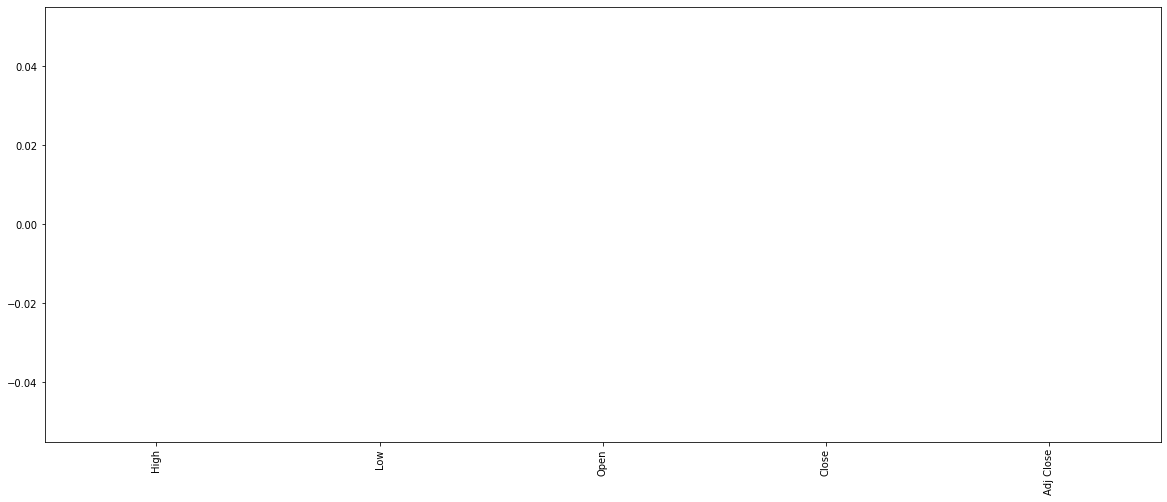

In [72]:
# Plot the P values
univariate.sort_values(ascending=False).plot.bar(figsize=(20,8))

In [73]:
# Select K percentile Features
k_percentile_features = SelectPercentile(f_regression, percentile=10).fit(X_train.fillna(0), y_train)
X_train.columns[k_percentile_features.get_support()]

Index(['Open'], dtype='object')

In [74]:
X_train = k_percentile_features.transform(X_train.fillna(0))
X_train.shape

(2151, 1)